In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten

In [4]:
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler

In [19]:
#load + preview data
matrixVar = loadmat("Xtrain.mat")
train_data = matrixVar['Xtrain']

In [16]:
#create sequences for training with chosen window size
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

def walk_forward_validation(data, window_size, scaler):
    # Scale the full dataset
    data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()

    X, y = create_sequences(data_scaled, window_size)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    predictions_scaled = []
    true_values_scaled = []
    mse_list = []

    for i in range(window_size, len(X) - 1):
        model = Sequential([
            Conv1D(filters=10, kernel_size=5, activation='relu', input_shape=(window_size, 1)),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')

        model.fit(X[:i], y[:i], epochs=10, verbose=0)

        y_pred_scaled = model.predict(X[i:i+1], verbose=0)[0][0]
        predictions_scaled.append(y_pred_scaled)
        true_values_scaled.append(y[i])

        # Calculate MSE on scaled values
        mse = mean_squared_error([y[i]], [y_pred_scaled])
        mse_list.append(mse)

    # Reshape for inverse transform
    predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)
    true_values_scaled = np.array(true_values_scaled).reshape(-1, 1)

    predictions_original = scaler.inverse_transform(predictions_scaled).flatten()
    true_values_original = scaler.inverse_transform(true_values_scaled).flatten()

    return true_values_original, predictions_original, mse_list



In [20]:
# Setup
window_size = 10
scaler = MinMaxScaler()

# Run walk-forward
true_vals, preds, mse_vals = walk_forward_validation(train_data, window_size, scaler)




/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(act

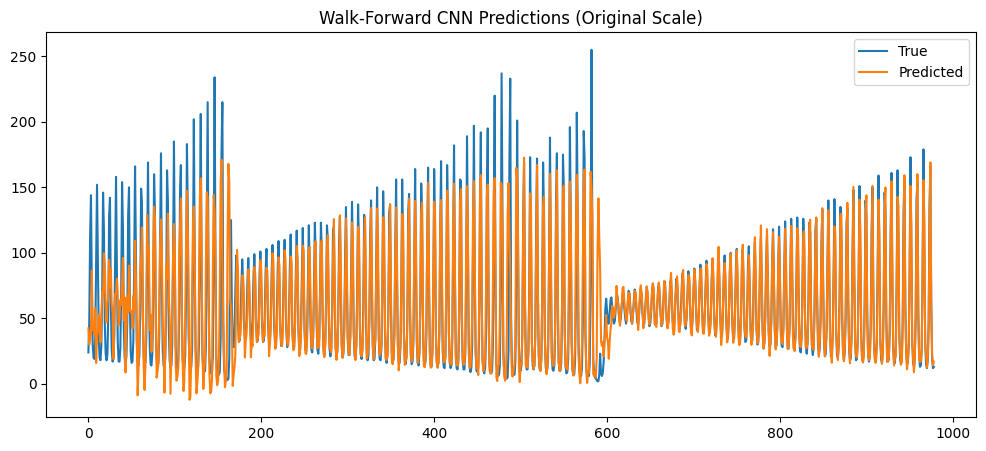

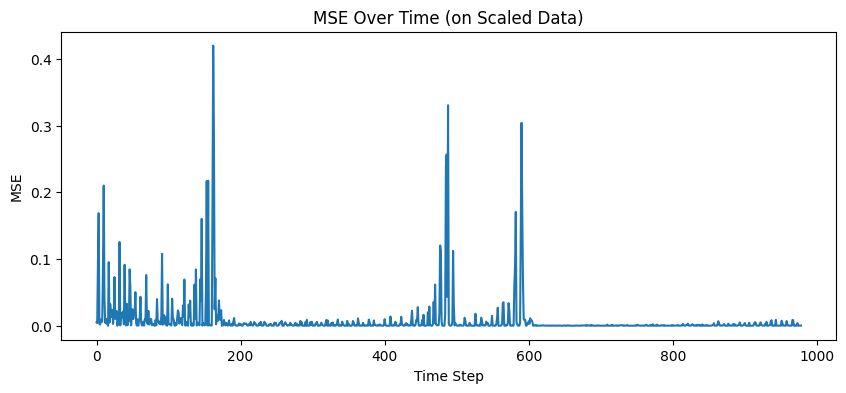

In [21]:
# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(true_vals, label='True')
plt.plot(preds, label='Predicted')
plt.title('Walk-Forward CNN Predictions (Original Scale)')
plt.legend()
plt.show()

# Plot MSE
plt.figure(figsize=(10, 4))
plt.plot(mse_vals)
plt.title('MSE Over Time (on Scaled Data)')
plt.xlabel('Time Step')
plt.ylabel('MSE')
plt.show()

In [22]:
np.average(mse_vals)

0.008461203982818025